In [1]:
import os
import sys
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
sys.path.append(module_path)

from keras import backend as K
from app.builder import Facenet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
ROOT = "../data/FaceData/"
path_haar = "../data/haarcascade_frontalface_default.xml"

In [3]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (160, 160))
    return image

In [4]:
def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders) * split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list


train_list, test_list = split_dataset(ROOT, split=1.0)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1324
Length of testing list : 0

Test List: {}


In [6]:
def create_triplets(directory, folder_list, max_files=10):
    anchors = []
    positives = []
    negatives = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files - 1):
            for j in range(i + 1, num_files):
                anchor = os.path.join(ROOT, folder, files[i])
                positive = os.path.join(ROOT, folder, files[j])

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.choice(
                    os.listdir(os.path.join(directory, neg_folder))
                )
                negative = os.path.join(ROOT, neg_folder, neg_file)

                anchors.append(anchor)
                positives.append(positive)
                negatives.append(negative)

    return anchors, positives, negatives

In [7]:
anchors, positives, negatives = create_triplets(ROOT, train_list)

print("Number of training triplets:", len(anchors))

print("\nExamples of triplets:")
for i in range(5):
    print(f'{anchors[i]} {positives[i]} {negatives[i]}')

Number of training triplets: 11231

Examples of triplets:
../data/FaceData/369\0.jpg ../data/FaceData/369\1.jpg ../data/FaceData/565\1.jpg
../data/FaceData/369\0.jpg ../data/FaceData/369\2.jpg ../data/FaceData/945\1.jpg
../data/FaceData/369\1.jpg ../data/FaceData/369\2.jpg ../data/FaceData/1348\1.jpg
../data/FaceData/886\0.jpg ../data/FaceData/886\1.jpg ../data/FaceData/1245\1.jpg
../data/FaceData/1544\0.jpg ../data/FaceData/1544\1.jpg ../data/FaceData/977\7.jpg


In [8]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchors)
positive_dataset = tf.data.Dataset.from_tensor_slices(positives)
negative_dataset = tf.data.Dataset.from_tensor_slices(negatives)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [9]:
image_count = len(anchors)
train_dataset = dataset.take(round(image_count * 0.9))
val_dataset = dataset.skip(round(image_count * 0.9))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

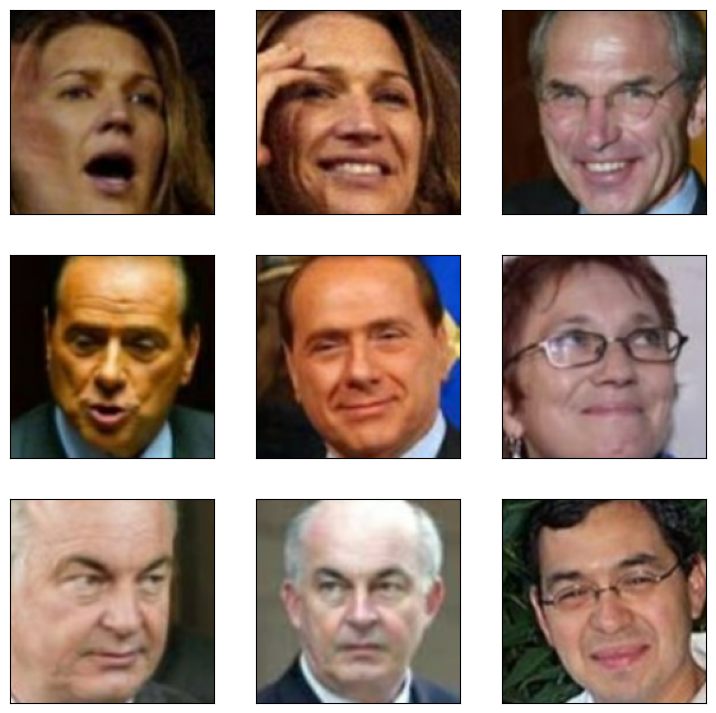

In [11]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [12]:
def get_encoder():
    pretrained_model = Facenet.loadModel()
    pretrained_model.trainable = True
    fine_tune_at = 355

    for layer in pretrained_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    last_layer = pretrained_model.get_layer("Dropout")
    last_output = last_layer.output
    # Bottleneck
    x = tf.keras.layers.Dense(256, use_bias=False, name="Bottleneck")(last_output)
    x = tf.keras.layers.BatchNormalization(
        momentum=0.995, epsilon=0.001, scale=False, name="Bottleneck_BatchNorm"
    )(x)

    model = tf.keras.models.Model(pretrained_model.input, x, name="Facenet_Model")
    
    return model

In [13]:
model = get_encoder()
model.summary()

Model: "Facenet_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                      

In [14]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [15]:
anchor_input = tf.keras.layers.Input((160, 160, 3), name="Anchor_Input")
positive_input = tf.keras.layers.Input((160, 160, 3), name="Positive_Input")
negative_input = tf.keras.layers.Input((160, 160, 3), name="Negative_Input")

distances = DistanceLayer()(
    model(anchor_input),
    model(positive_input),
    model(negative_input),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances,
    name="Siamese_Network",
)

In [16]:
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 160, 160, 3  0           []                               
                                )]                                                  

In [17]:
class SiameseModel(tf.keras.Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [18]:
siamese_model = SiameseModel(siamese_network)

In [19]:
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5))
history = siamese_model.fit(train_dataset, epochs=150, validation_data=val_dataset)

Epoch 1/150
316/316 [==============================] - 73s 153ms/step - loss: 0.0944 - val_loss: 0.0456
Epoch 2/150
316/316 [==============================] - 43s 138ms/step - loss: 0.0178 - val_loss: 0.0343
Epoch 3/150
316/316 [==============================] - 46s 145ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 4/150
316/316 [==============================] - 46s 144ms/step - loss: 9.1893e-04 - val_loss: 0.0112
Epoch 5/150
316/316 [==============================] - 45s 142ms/step - loss: 8.6740e-05 - val_loss: 0.0114
Epoch 6/150
316/316 [==============================] - 44s 140ms/step - loss: 2.5834e-05 - val_loss: 0.0118
Epoch 7/150
316/316 [==============================] - 43s 136ms/step - loss: 4.1358e-05 - val_loss: 0.0126
Epoch 8/150
316/316 [==============================] - 43s 135ms/step - loss: 6.7303e-05 - val_loss: 0.0055
Epoch 9/150
316/316 [==============================] - 42s 132ms/step - loss: 9.5705e-04 - val_loss: 0.0050
Epoch 10/150
316/316 [==================

In [20]:
def extract_encoder(model):
    encoder = get_encoder()
    i = 0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i += 1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("siamese.h5")
encoder.summary()

Model: "Facenet_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_2[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                      

In [21]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1 - tensor2), axis=-1)
    prediction = np.where(distance <= threshold, 0, 1)
    return prediction

1/1 [==============================] - 0s 19ms/step

Accuracy of model: 0.5



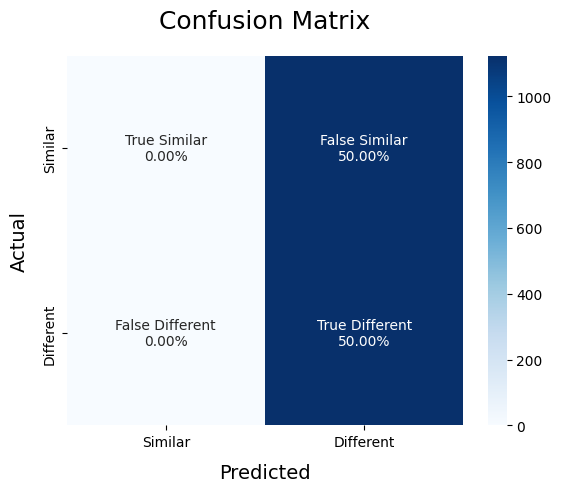

In [22]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0] * len(pos_list) + [1] * len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories = ["Similar", "Different"]
    names = ["True Similar", "False Similar", "False Different", "True Different"]
    percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]

    labels = [f"{v1}\n{v2}" for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(
        cf_matrix,
        annot=labels,
        cmap="Blues",
        fmt="",
        xticklabels=categories,
        yticklabels=categories,
    )

    plt.xlabel("Predicted", fontdict={"size": 14}, labelpad=10)
    plt.ylabel("Actual", fontdict={"size": 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={"size": 18}, pad=20)


pos_list = np.array([])
neg_list = np.array([])

for data in val_dataset.take(100):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))

ModelMetrics(pos_list, neg_list)